In [2]:
from sclibrary.network_reader import NetworkReader
from sclibrary.simplicial_complex import SimplicialComplexNetwork
import numpy as np
import matplotlib.pyplot as plt

from sclibrary.eigendecomposition import get_eigendecomposition

### Reading data

In [3]:
data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, 
                           src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)

simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")


# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)

### Denoising Edge flow

In [4]:

L1 = sc.hodge_laplacian_matrix(rank=1)
L1U = sc.upper_laplacian_matrix(rank=1)
L1L = sc.lower_laplacian_matrix(rank=1)


# eigen decomposition
u_1, eigenvals_u1 = get_eigendecomposition(L1)
u_1U, eigenvals_u1U = get_eigendecomposition(L1U)
u_1L, eigenvals_u1L = get_eigendecomposition(L1L)

In [5]:
# noise-free flow f0
f0 = u_1 @ np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    
"""
-0.208098
1.431325
-2.494638
0.362076
-1.166965
-0.122621
-2.213600
-0.970141
-1.029267
-0.036741
"""


# noisy flow f
f = np.array([
    -0.208098,
    1.431325,
    -2.494638,
    0.362076,
    -1.166965,
    -0.122621,
    -2.213600,
    -0.970141,
    -1.029267,
    -0.036741 
])

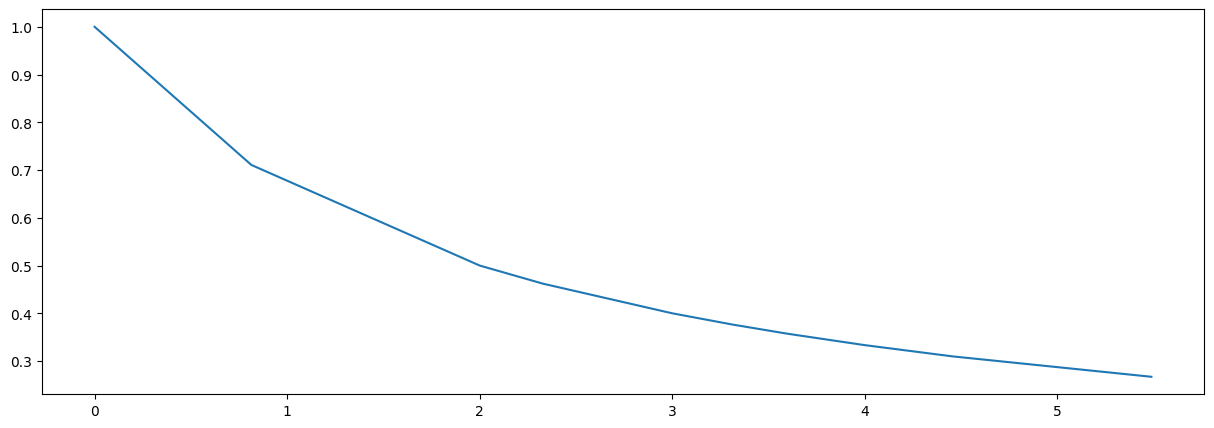

In [6]:

import numpy as np

# perform denoising by regularization solution
I = np.eye(L1.shape[0])
B1 = sc.incidence_matrix(rank=1)
# Use P as the edge laplacian
P = B1.T @ B1
A_lg = np.abs(P - 2 * I)
L_lg = np.diag(A_lg) - A_lg

# regularization parameters
mu_vals = [0.5]
errors = np.zeros((len(mu_vals)))

for i, mu in enumerate(mu_vals):
    # denoising with low pass filter Hp 
    H_regularized = np.linalg.inv(L1 * mu + I)
    H_regularized_freq = np.diag(u_1.T @ H_regularized @ u_1)

    f_est_r = H_regularized @ f
    errors[i] = np.linalg.norm(f_est_r - f0) / np.linalg.norm(f0)

# plot the H regualrized solution
plt.figure(figsize=(15, 5))
plt.plot(eigenvals_u1, H_regularized_freq)

### Grid based filter design

In [7]:
# approzimate largest true eigenvalue using power iteration method
# power iteration
v = np.ones(L1.shape[0])
for i in range(50):
    v = L1 @ v
    v = v / np.linalg.norm(v)
v

array([ 0.05882426, -0.32941538,  0.14631812, -0.38823965,  0.4757335 ,
        0.49026405, -0.30516876,  0.31969932,  0.12266404, -0.19703528])

In [8]:
# sample M1 and M2 grid points unoformly in the interval
# for the smalles, set value grater than 0 as the lower bound
lambda_min = 0
lambda_max = np.mean(L1 @ v / v)

# number of samples
num_of_samples = 10

# sample grid points from eigenvalues
eigenvals_sampled = np.linspace(lambda_min, lambda_max, num_of_samples)
eigenvals_sampled

array([0.        , 0.60977585, 1.21955171, 1.82932756, 2.43910341,
       3.04887927, 3.65865512, 4.26843098, 4.87820683, 5.48798268])

In [9]:
# Grid based filter design
def frequecy_response(eigenvalue, mu=0.5):
    return 1 / (1 + mu * eigenvalue)

# frequency response requirement vector
g = [frequecy_response(eigenvals_sampled[i]) for i in range(num_of_samples)]
# true frequency response
g_true = [frequecy_response(eigenvals_u1[i]) for i in range(num_of_samples)]

Text(0.5, 1.0, 'Frequency responses of the denoising filter Hp based on the grid design')

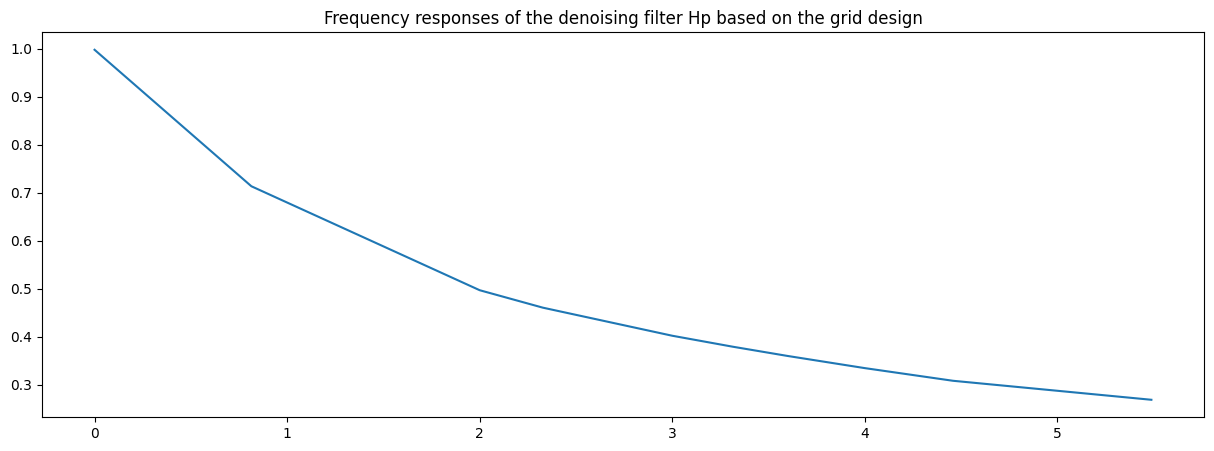

In [10]:
filter_range = range(12)

# learn the regularization filter with topological filter
system_mat = np.zeros((len(eigenvals_sampled), len(filter_range)))
system_mat_true = np.zeros((len(eigenvals_u1), len(filter_range)))

errors_tf = np.zeros((len(filter_range)))
errors_filter = np.zeros((len(filter_range)))
errors_filter_true = np.zeros((len(filter_range)))

L1 = np.array(L1, dtype=object)

for l in filter_range:
    # building the system matrix
    system_mat[:, l] = np.power(eigenvals_sampled, l)
    system_mat_true[:, l] = np.power(eigenvals_u1, l)
    
    # solve the system using least squares solution to obtain filter coefficients
    h = np.linalg.lstsq(system_mat, g, rcond=None)[0]
    h_true = np.linalg.lstsq(system_mat_true, g_true, rcond=None)[0]
    
    # build the topology filter
    H = np.zeros_like(L1, dtype=object)
    H_true = np.zeros_like(L1, dtype=object)
    
    for i in range(len(h)):
        #print("i", i)
        H += h[i] * np.linalg.matrix_power(L1, i)
        H_true += h_true[i] * np.linalg.matrix_power(L1, i)
        
    #print(H)
    
    # denosing with Hp filter   
    f_est = H @ f
    # compute errors
    errors_tf[l] = np.linalg.norm(f_est - f0) / np.linalg.norm(f0)
    errors_filter[l] = np.linalg.norm(H - H_regularized)
    errors_filter_true[l] = np.linalg.norm(H - H_true)
    
    # frequency response of the filter
    H_freq = np.diag(u_1.T @ H @ u_1)
    
    if l == 4:
        plt.figure(figsize=(15, 5))
        plt.plot(eigenvals_u1, H_freq)
        
        
plt.title("Frequency responses of the denoising filter Hp based on the grid design")

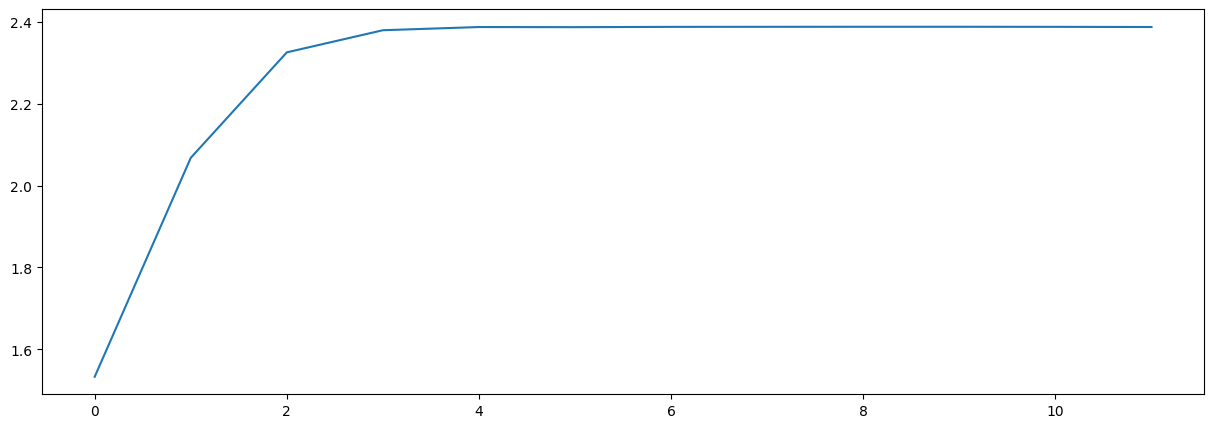

In [11]:
# plt the error
plt.figure(figsize=(15, 5))
plt.plot(filter_range, errors_tf)

#### Chebyshev

In [39]:
f = np.array([
    0.2851,
    -0.8824,
    -1.3731,
    1.2467,
    -0.9050,
    0.7202,
    0.5628,
    -1.1828,
    1.3918,
    0.8425
])

_, _, f_g = sc.get_hodgedecomposition(flow=f)

print(f)
print(f_g)

[ 0.2851 -0.8824 -1.3731  1.2467 -0.905   0.7202  0.5628 -1.1828  1.3918
  0.8425]
[-0.64 -0.31 -1.02  0.32 -0.71  0.17  1.11 -0.24  1.    1.24]


In [13]:
# estimate largest eigenvalue using power iteration method
v = np.ones(L1L.shape[0])
for i in range(50):
    v = L1L @ v
    v = v / np.linalg.norm(v)

print("v", v)
# mean of the largest eigenvalue
lamda_g_max = np.mean(L1L @ v / v)
print("lamda_g_max", lamda_g_max)

v [ 0.05882426 -0.32941538  0.14631812 -0.38823965  0.4757335   0.49026405
 -0.30516876  0.31969932  0.12266404 -0.19703528]
lamda_g_max 5.4879826825028015


In [14]:
from chebpy import chebfun

# cut off frequency - gradient
cut_off_freq_g = 0.01
steep = 100
# logistic function to perform gradient component extraction
g_g = lambda lam: 1 / (1 + np.exp(-steep * (lam - cut_off_freq_g)))
g_g_cheb = chebfun(g_g, [0, lambda_max], 100)
# filter coefficients
coeffs_g = g_g_cheb.funs[0].coeffs
coeffs_g

array([ 9.75247591e-01,  4.93662867e-02, -4.89526174e-02,  4.82695494e-02,
       -4.73265143e-02,  4.61364404e-02, -4.47154865e-02,  4.30827118e-02,
       -4.12596907e-02,  3.92700846e-02, -3.71391788e-02,  3.48933998e-02,
       -3.25598222e-02,  3.01656793e-02, -2.77378881e-02,  2.53025993e-02,
       -2.28847825e-02,  2.05078542e-02, -1.81933560e-02,  1.59606882e-02,
       -1.38269010e-02,  1.18065464e-02, -9.91158923e-03,  8.15137767e-03,
       -6.53266749e-03,  5.05969801e-03, -3.73431303e-03,  2.55612109e-03,
       -1.52268809e-03,  6.29755249e-04,  1.28524641e-04, -7.59339874e-04,
        1.27096795e-03, -1.67252543e-03,  1.97372507e-03, -2.18464518e-03,
        2.31551510e-03, -2.37652027e-03,  2.37762901e-03, -2.32844289e-03,
        2.23807127e-03, -2.11503022e-03,  1.96716531e-03, -1.80159715e-03,
        1.62468822e-03, -1.44202913e-03,  1.25844209e-03, -1.07799955e-03,
        9.04055321e-04, -7.39286150e-04,  5.85741170e-04, -4.44897225e-04,
        3.17717934e-04, -

Text(0.5, 1.0, 'Frequency response on the gradient eigen_values - chebyshev approx.')

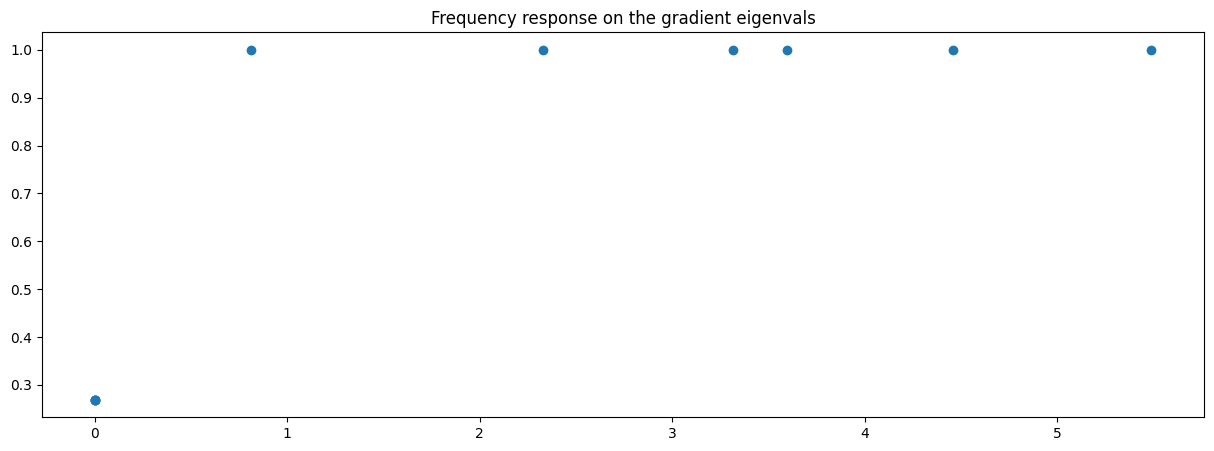

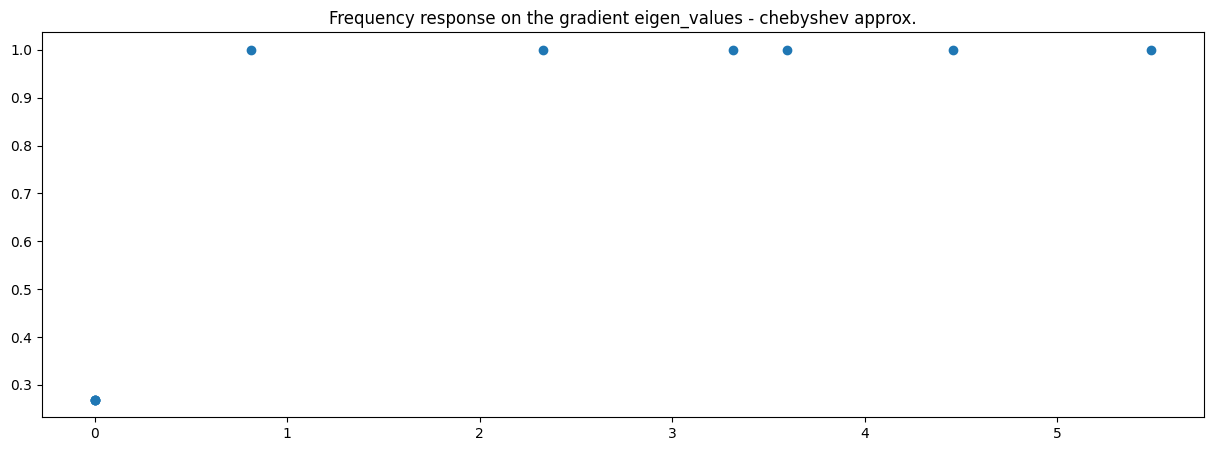

In [15]:
# plot the continuous frequency response 
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_u1L, g_g(eigenvals_u1L))
plt.title("Frequency response on the gradient eigenvals")

plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_u1L, g_g_cheb(eigenvals_u1L))
plt.title("Frequency response on the gradient eigen_values - chebyshev approx.")

difference 1.913538576985806


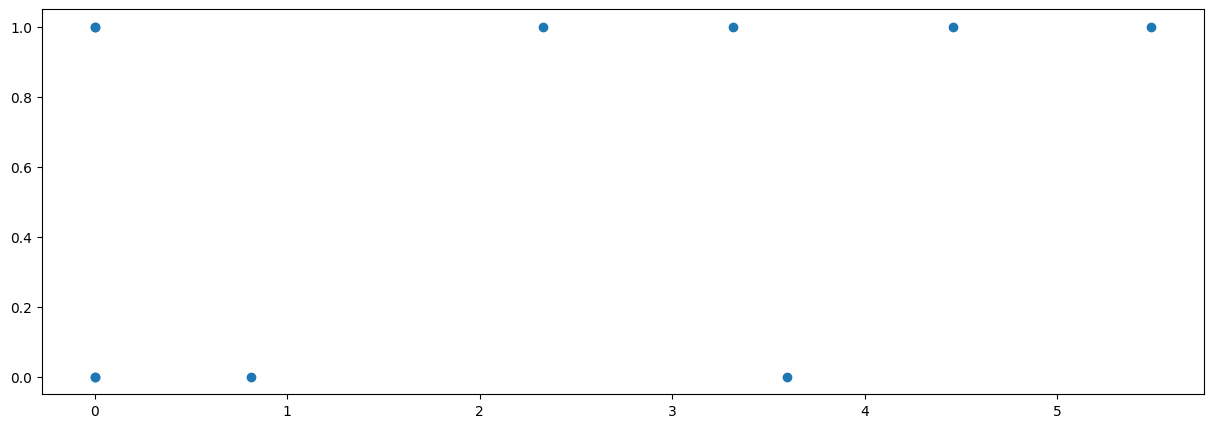

In [28]:
component = "gradient"

# the ideal frequency response
u_g, _ = sc.get_eigendecomposition(component)
h_g_ideal = sc.get_component_coefficients(component)
H_g_ideal = u_1L @ np.diag(h_g_ideal) @ u_1L.T

# difference 
print("difference", np.linalg.norm(H_g_ideal - u_g @ u_g.T))

# pplo the ideal frequency response
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_u1L, h_g_ideal)

In [29]:
# perform a transformation to shit the domain to [0, lambda_g_max]
alpha_g = lamda_g_max / 2
points = (eigenvals_u1L - alpha_g) / alpha_g


def chebychev_approx(points, coeffs_g):
    # create a chebyshev polynomial approx
    # approx_vals = g_g_cheb(points)
    # return approx_vals
    approx_vals = np.polynomial.chebyshev.chebval(x=points, c=coeffs_g)
    return approx_vals
    

# domain [-1, 1]
print("points transformation")
print(points)
# domain [0, lamda_max]
chebychev_approx(points, coeffs_g)

points transformation
[-1.         -1.         -1.         -1.         -0.70322456 -0.15159749
  0.20769609  0.31126123  0.62446925  1.00004833]


array([0.26894142, 0.26894142, 0.26894142, 0.26894142, 1.0000044 ,
       1.00000725, 1.00000182, 0.99999437, 1.00000262, 0.99999996])

In [40]:
import numpy as np

def filter_cheb_approx(L1L, coeffs_g, alpha_g, k):
    # implement the filter approximation
    # P0(L1L) = I
    # P1(L1L) = (2 / lamda_g_max) * L1L - I
    # Pl(L1L) = 2 * P1 (L1L) * Pl-1 (L1L) - Pl-2 (L1L)
    
    # Hl = (1/2) * cl,0 * I + sum(cl,i * Pl(L1L))
    #print(L1L.shape)
    #print(coeffs_g.shape)
    el = L1L.flatten()[k]
    res = coeffs_g[k] * np.polynomial.chebyshev.chebval(el, c=coeffs_g)
    return res

# truncated order 
K_trunc = range(5, 100, 5)

H_g_cheb_approx_out = np.zeros((len(K_trunc), L1L.shape[0], L1L.shape[1]))

for k in range(len(K_trunc)):
    x = filter_cheb_approx(L1L, coeffs_g, alpha_g, K_trunc[k])
    H_g_cheb_approx_out[k:, :, :] = x
    

errors_g_response = np.zeros((len(K_trunc)))
errors_filter = np.zeros((len(K_trunc)))

f_g_cheb = np.zeros((L1L.shape[0], len(K_trunc)))
f_g_cheb_tilde = np.zeros((L1L.shape[0], len(K_trunc)))

error_g_tilde = np.zeros((len(K_trunc)))
error_g = np.zeros((len(K_trunc)))

for k in range(len(K_trunc)):
    g_g_cheb_approx = np.diag(u_1L.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ u_1L)
    # compute the error
    errors_g_response[k] = np.linalg.norm(g_g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)
    errors_filter[k] = np.linalg.norm(np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2)
    
    f_g_cheb[:, k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    f_g_cheb_tilde[:, k] = u_1 @ f_g_cheb[:, k]
    
    error_g_tilde[k] = np.linalg.norm(f_g_cheb_tilde[:, k] - u_1.T * f_g) / np.linalg.norm(u_1.T * f_g)
    error_g[k] = np.linalg.norm(f_g_cheb[:, k] - f_g) / np.linalg.norm(f_g)
    
errors_g_response

array([9.83372453e-01, 1.02226670e+00, 9.96762951e-01, 1.00739176e+00,
       9.97567711e-01, 9.99982885e-01, 1.00029197e+00, 9.98905960e-01,
       1.00072013e+00, 9.99710894e-01, 4.94999503e+46, 1.00010607e+00,
       9.99887092e-01, 1.00007370e+00, 9.99969444e-01, 1.00000236e+00,
       1.00000937e+00, 9.99989324e-01, 1.00000231e+00])

In [43]:
error_g

array([9.95888211e-01, 1.00457471e+00, 9.99283571e-01, 1.00157221e+00,
       9.99463700e-01, 9.99996265e-01, 1.00006363e+00, 9.99760194e-01,
       1.00015668e+00, 9.99936843e-01, 1.84372386e+46, 1.00002313e+00,
       9.99975352e-01, 1.00001608e+00, 9.99993332e-01, 1.00000052e+00,
       1.00000204e+00, 9.99997671e-01, 1.00000050e+00])

In [31]:
from chebpy import chebfun

f = lambda x: (2 / lamda_g_max) * x - 1
g = chebfun(f, n = 2)
g.funs[0](1)

-0.6355673631448309